In [1]:
from models.LeNet import LeNet
import pandas as pd
from matplotlib import pyplot as plt
import torch

In [2]:
lenet = LeNet()

Model weights loaded successfully


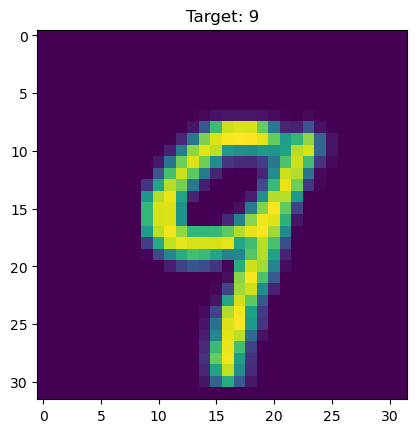

In [3]:
ex_num = 12
x0, y = lenet.test_dataset[ex_num]
x0_np = x0.squeeze()
plt.imshow(x0_np)
plt.title(f"Target: {y}")
plt.show()

In [30]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = lenet.model.to(device)
model.eval()

# Detatch PARAMETERS from computational graph
# This is so we dont waste time calculating gradient of params (only used for training)
# can still calulate grad wrt input wich is used for attacks
for param in model.parameters():
    param.requires_grad = False

# for target attacks you can define a custom loss here
criterion = lenet.cost#nn.CrossEntropyLoss()

def input_grad(x_t):
    # Prepare the input tensor
    input_tensor = x_t.view(1, 1, 32, 32).to(device)
    input_tensor.requires_grad_()

    # Forward pass
    outputs = model(input_tensor)
    target_tensor = torch.tensor([y]).to(device)
    loss = criterion(outputs, target_tensor)
    _, predicted_class = outputs.max(1)

    # Backward pass to compute the gradients
    loss.backward()
    return input_tensor.grad, loss.item(), predicted_class.item()

input_gradient, _, _= input_grad(x0)
print(input_gradient)
torch.norm(input_gradient)

tensor([[[[ 1.2259e-07,  1.5092e-07,  1.2914e-07,  ..., -4.7472e-09,
           -1.0465e-08,  0.0000e+00],
          [ 6.6821e-08,  1.3236e-07, -2.6092e-08,  ...,  2.7290e-09,
           -1.1225e-08,  0.0000e+00],
          [-3.0564e-07, -4.7386e-07, -2.3172e-06,  ...,  6.2466e-07,
            1.0746e-06,  0.0000e+00],
          ...,
          [ 3.7814e-08,  6.8624e-09,  7.6115e-08,  ...,  1.0918e-06,
            4.0120e-07,  0.0000e+00],
          [ 7.1740e-08,  5.6028e-08,  1.9645e-07,  ..., -9.7012e-07,
            6.7897e-07,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]]])


tensor(0.0002)

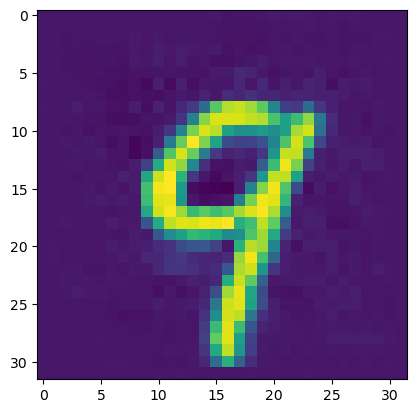

In [31]:
plt.imshow((x0 + 10000*input_gradient).squeeze())

# Frank-Wolfe White-box Attack Algorithm
As formulated by alg. 1 in attacks.pdf  
Different from standard FW because of momentum

In [33]:
eps = 1e-2 # Max perturbation
max_iter = 1000
gamma_t = 1 # step size
beta = 0.5 # momentum term

# gradient does not need to be tracked in the FW
# is handeled in the input_gradient method
x_t = x0.detach().clone() 
m_t, _, _ = input_grad(x_t)
hist = []

for i in range(max_iter):
    g_t, loss_value, y_pred = input_grad(x_t)
    m_t = beta * m_t + (1 - beta) * g_t
    # LMO - for infinity norm
    v_t = -eps * m_t.sign() + x0
    d_t = v_t - x_t
    x_t = x_t + gamma_t*d_t

    # metrics
    hist.append({
        'loss': loss_value,
        'y_pred': y_pred
    })
hist = pd.DataFrame(hist)

In [34]:
hist

,loss,y_pred
0,0.000040,9
1,0.000019,9
2,0.000018,9
3,0.000018,9
4,0.000018,9
...,...,...
995,0.000018,9
996,0.000018,9
997,0.000018,9
998,0.000018,9


<Axes: >

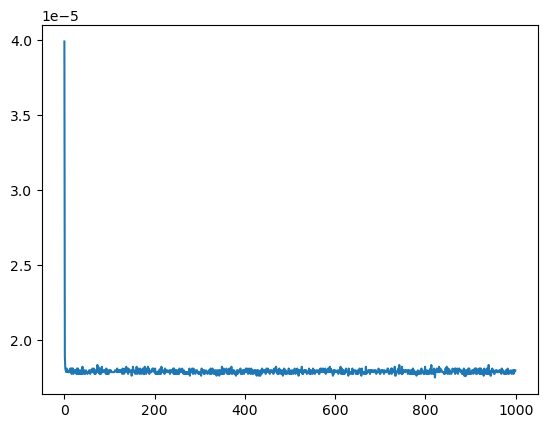

In [28]:
hist['loss'].plot()

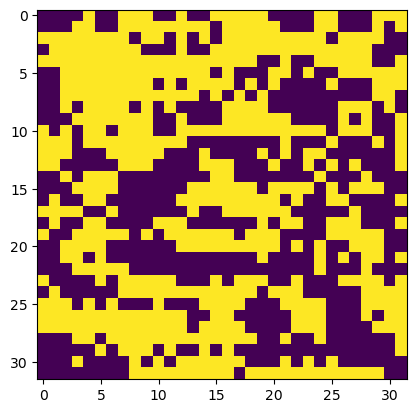

In [29]:
plt.imshow((x_t - x0).squeeze())